## QCAMP 2025
# Tutorial: Deep Learning Meets Quantum Many-Body Physics: from Foundations to Applications 
#### Author: Marcin Plodzień 
#### Affiliation: ICFO - Institute of Photonic Sciences; Qilimanjaro Quantum Tech
#### Email: marcin.plodzien@icfo.eu, marcin.plodzien@qilimanjaro.tech
#### Links:
1. [Marcin Plodzien Physics](https://sites.google.com/site/marcinplodzienphysics/home)
2. [GitHub](https://github.com/MarcinPlodzien) https://github.com/MarcinPlodzien 
3. [arxiv](https://arxiv.org/search/?query=P%C5%82odzie%C5%84%2C+Marcin&searchtype=author&abstracts=show&order=-announced_date_first&size=50)
   
###### Edited by: [Gerardo Suarez](https://gsuarezr.github.io)
###### Affiliation: ICTQT - International Centre for the Theory of Quantum Technologies

### Crash Introduction to the Heisenberg Model

The Heisenberg Model is a Foundational model in condensed matter physics. It describes the magnetic behaviour of magnetic materials. In this model spins can point in any direction in 3D space, It is a generalization of the 1D Ising model

In the simplest case the $XXX$ model, the Hamiltonian of this model is given by

$$H = - J \sum_{i,j=ij} \vec{\sigma}_{i}\cdot\vec{\sigma}_{j}$$

The sign of $J$ determines the magnetic behaviour of the ground state

- If $J<0$ the system is Ferromagnetic, meaning that neighboring spins align parallel to each other
- If $J>0$ the system is Anti-Ferromagnetic, meaning that neighboring spins align antiparallel to each other

# One-dimensional XXZ Heisenberg model with Transverse Field: A Tutorial
In this tutorial, we will consider the phase diagram of the **quantum XXZ Heisenberg model** in the presence of a **transverse field**. Next, we will use dimensionality reduction techniques, namely PCA and t-SNE, to investigate distinct quantum phases in the model.

### Model Hamiltonian

The general one-dimensional quantum Heisenberg Hamiltonian with transverse field (open boundary conditions) is given by:
\begin{equation}
H = - \sum_{i=1}^{L-1} \left( J_x\hat{\sigma}^x_i \hat{\sigma}^x_{i+1} + J_y\hat{\sigma}^y_i \hat{\sigma}^y_{i+1} + \Delta \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} \right) 
    - h_z \sum_{i=1}^L \hat{\sigma}^z_i
\end{equation}
where:
- $\hat{\sigma}^{x,y,z}_i$ are spin operators at site $i$ in a spin-$1/2$ chain,
- $\Delta$ is the anisotropy parameter,
- $h_z$ is the transverse field in the $z$-direction.

When $J_x = J_y = J_z$ we deal with $XXX$ Hamiltonian, while when $J_y = \Delta = 0$, and $J_x\ne0$ we have quantum Ising model in a transverse field. The XXZ model (without transverse field) is exactly solvable by Bethe ansatz.

These models a cornerstone in quantum many-body physics, providing insights into quantum entanglement and spin interactions, see
1. Textbook: [Quantum Physics in One Dimension](https://academic.oup.com/book/27811) by Thierry Giamarchi.
2. Textbook: [An Introduction to Integrable Techniques for One-Dimensional Quantum Systems](https://link.springer.com/book/10.1007/978-3-319-48487-7) by Fabio Franchini.
3. Introduction to exactly solvable spin-$1/2$ models: [A pedagogical introduction to quantum integrability, with a view towards theoretical high-energy physics](https://pos.sissa.it/232/001)
4. [Modern Statistical Mechanics](https://users.ox.ac.uk/~phys1116/book.html) by Paul Fendley.



These models are topic of many research studies, focusing on their realization on quantum hardware, as examples you can see:
1. [Preparing ground states of the XXZ model using the quantum annealing with inductively coupled superconducting flux qubits](https://arxiv.org/pdf/2112.12419)
2. [Exact Ising model simulation on a quantum computer](https://quantum-journal.org/papers/q-2018-12-21-114/)


To study numerically the model allowing extracting its thermodynamics limit (i.e. infinite system size) properties it is necessarry to consider large number of spins $L\gg 1$. The state-of-the-art numerical methods are based on tensor networks, Matrix Product States, and DMRG calculations. Here, we will work with small system sizes $L \le 10$, and we will construct exact matrix representation of the Hamiltonian, diagonalize it, calculate ground state and its properties.

### XXZ model
In this tutorial we will study, withing the Exact Diagonalization approach, the XXZ model ($J_x = J_y = 1 \ne \Delta$) in a transverse field
$h_z \ge 0$:
\begin{equation}
H = - \sum_{i=1}^{L-1} \left( \hat{\sigma}^x_i \hat{\sigma}^x_{i+1} + \hat{\sigma}^y_i \hat{\sigma}^y_{i+1} + \Delta \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} \right) 
    - h_z \sum_{i=1}^L \hat{\sigma}^z_i
\end{equation}

In particular, we will

1. Construct the Hamiltonian for $L$ spins.
2. Perform exact diagonalization to find the ground state and compute observables.
3. Calculate entanglement entropy and analyze system properties.
4. Visualize the results.


The goal is to analyze ground state properties of the model for small system size $L$.

We need to start with definitions of many-body operators acting on $L$ spins-$1/2$ chain.


In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.linalg import eigh, cholesky
import itertools
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from functools import reduce
import torch as pt # commonly imported as torch
from matplotlib.patches import Rectangle
import os

In [2]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

### Function Definitions
The following functions are used throughout this notebook:
1. **Fock Basis Generation:** `generate_fock_basis` generates all possible spin configurations.
2. **Operators Construction:** `construct_operator` and `total_spin_operator` build spin operators for the system.

In [3]:
def generate_fock_basis(L):
    """
    Generate the Fock basis for L spins.

    Parameters:
        L (int): Number of spins.

    Returns:
        tuple: A tuple containing:
            - list of tuples: List where each tuple is a basis vector.
            - dict: Dictionary with spin vectors as keys and their indices as values.
    """
    # Total number of basis states is 2**L
    num_states = 2 ** L

    # Generate all basis vectors as binary representations of integers
    basis = []
    index_map = {}
    for i in range(num_states):
        binary_representation = format(i, f"0{L}b")  # Binary string with L bits
        spin_vector = tuple(1 - 2 * int(bit) for bit in binary_representation)  # Map 0 -> +1 (up), 1 -> -1 (down)
        basis.append(spin_vector)
        index_map[spin_vector] = i
    return basis, index_map


$$\sigma_{i}^{j} = 1 \otimes \dots \otimes 1 \otimes \sigma_{i} \otimes \dots \otimes 1 $$
$$S_{i} = \sum_{j}\sigma_{i}^{j}$$

In [35]:

def construct_sigma_operator(sigma, L, site):
    """
    Constructs an operator acting on a specific site in an L-spin system.

    Args:
        pauli (np.ndarray): Pauli matrix for the operator.
        L (int): Number of spins.
        site (int): Site index (0-based) where the operator acts.

    Returns:
        np.ndarray: Operator acting on the full L-spin system.
    """
    operators = [identity if i != site else sigma for i in range(L)]
    return reduce(np.kron, operators)

def total_sigma_operator(L, sigma):
    """
    Construct the total spin operator for a specific component.

    Args:
        L (int): Number of spins.
        pauli (np.ndarray): Pauli matrix for the spin component (x, y, or z).

    Returns:
        np.ndarray: Total spin operator matrix.
    """
    return sum(construct_sigma_operator(sigma, L, i) for i in range(L))


### Function Definitions

The following functions are used throughout this notebook:
1. **Hamiltonian Construction:** `xxz_hamiltonian` constructs the XXZ model Hamiltonian.
2. **Exact Diagonalization:** `exact_ground_state` finds the ground state of the Hamiltonian.
3. **Entanglement Entropy:** Functions to compute partial traces and von Neumann entropy.


In [4]:
def xxz_hamiltonian(L, delta, hz):
    """
    Construct the XXZ Hamiltonian for L spins with anisotropy delta.

    Args:
        L (int): Number of spins.
        delta (float): Anisotropy parameter.
        h (float): transverse field

    Returns:
        np.ndarray: The XXZ Hamiltonian matrix.
    """
    H = np.zeros((2**L, 2**L), dtype=complex)
    for i in range(L-1):

        j = i+1
 
        sigma_x_i = construct_sigma_operator(sigma_x, L, i)
        sigma_x_j = construct_sigma_operator(sigma_x, L, j)
        
        sigma_y_i = construct_sigma_operator(sigma_y, L, i)
        sigma_y_j = construct_sigma_operator(sigma_y, L, j)
        
        sigma_z_i = construct_sigma_operator(sigma_z, L, i)
        sigma_z_j = construct_sigma_operator(sigma_z, L, j)
      
        H += -( np.dot(sigma_x_i, sigma_x_j) + np.dot(sigma_y_i, sigma_y_j) + delta * np.dot(sigma_z_i, sigma_z_j) ) 
    
    for i in range(L):
        sigma_z_i = construct_sigma_operator(sigma_z, L, i)
        H += -hz*sigma_z_i
        
    return H


$$H\ket{\psi_{0}}= E_{0} \ket{\psi_{0}}$$
$$\rho = \ket{\psi_{0}} \bra{\psi_{0}}$$

In [39]:
 
def exact_ground_state(H):
    """
    Compute the ground state of a Hamiltonian via exact diagonalization.

    Args:
        H (np.ndarray): Hamiltonian matrix.

    Returns:
        tuple: Ground state wavefunction and its energy.
    """
    eigenvalues, eigenvectors = eigh(H)
    psi_0 = eigenvectors[:, 0]  
    return psi_0,  eigenvalues[0:5]

def density_matrix(psi):
    """
    Construct the density matrix for a given state.

    Args:
        psi (np.ndarray): Wavefunction.

    Returns:
        np.ndarray: Density matrix.
    """
    return np.outer(psi, psi.conj())

In [40]:

def cholesky_matrix_to_cholesky_vector(A):
    """
    Extract the non-zero elements of the lower triangular part of a Cholesky matrix A 
    (including the diagonal) into a vector.

    Args:
        A (np.ndarray): Cholesky matrix (assumed to be square and possibly complex).

    Returns:
        np.ndarray: Vector containing non-zero elements of the lower triangular part.
    """
    if not isinstance(A, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    if A.shape[0] != A.shape[1]:
        raise ValueError("Input matrix must be square.")
    
    # Extract the lower triangular part
    A_LT = np.tril(A)
    
    # Select non-zero elements only
    non_zero_indices = np.tril_indices(A.shape[0])
    L_real = np.real(A_LT[non_zero_indices])
    L_imag = np.imag(A_LT[non_zero_indices])
    
    # Concatenate real and imaginary parts
    return np.concatenate([L_real, L_imag])


In [41]:
def cholesky_vector_to_cholesky_matrix(vector):
    """
    Reconstruct a Cholesky matrix from a vector containing non-zero elements 
    of its lower triangular part (including diagonal).

    Args:
        vector (np.ndarray): Flattened vector containing real and imaginary parts of non-zero elements.

    Returns:
        np.ndarray: Reconstructed Cholesky matrix, potentially complex.
    """
    # Determine the total number of elements in the lower triangular part
    num_elements = len(vector) // 2  # Each element has real and imaginary parts

    # Solve for n using the quadratic formula
    n = int((-1 + np.sqrt(1 + 8 * num_elements)) / 2)
    
    if n * (n + 1) // 2 != num_elements:
        raise ValueError("Invalid vector length: cannot correspond to a lower triangular matrix.")

    # Split the vector into real and imaginary parts
    half_length = len(vector) // 2
    L_real = vector[:half_length]
    L_imag = vector[half_length:]
    
    # Combine into a complex array if imaginary part exists
    L = L_real + 1j * L_imag

    # Initialize an empty matrix
    A = np.zeros((n, n), dtype=complex)

    # Fill in the lower triangular part
    tril_indices = np.tril_indices(n)
    A[tril_indices] = L

    return A
    

$$S(\rho_{A}) = \rho_{A} \log(\rho_{A}) = \rho_{B} \log(\rho_{B}) = S(\rho_{B}) $$

In [42]:
def get_SvN(rho):
    """ Calculate reduced density matrix rho_A = Tr_B[rho_AB]
        and its von Neuman entanglement entropy S_vN = -Tr[rho_A log[rho_A]]
    """
    rho_A = np.zeros((2**L_A, 2**L_A), dtype = np.complex128)
    for ket_v_A in fock_basis_A:
        idx_v_A = index_map_A[ket_v_A]
        for ket_w_A in fock_basis_A:
            idx_w_A = index_map_A[ket_w_A]
            for ket_v_B in fock_basis_B:
                ket_v_A_v_B = ket_v_A + ket_v_B
                ket_w_A_v_B = ket_w_A + ket_v_B
                
                idx_1 = index_map_AB[ket_v_A_v_B]
                idx_2 = index_map_AB[ket_w_A_v_B]
                
                rho_A[idx_v_A, idx_w_A] += rho[idx_1, idx_2]
                
    lambdas = np.linalg.eigvalsh(rho_A)
    SvN = 0
    epsilon = 1e-10
    for lambda_ in lambdas:
        SvN = SvN - lambda_*np.log(lambda_ + epsilon)
    return rho_A, SvN


### Main Simulation

Now, we will we compute the ground state, and calulcate expectation values for the XXZ model for fixed system size $L$ for various values of:
- Anisotropy parameter $\Delta$
- Transverse field $h_z$

We will collect:
1. Ground state $|\psi_{gs}\rangle$
2. Eigenenergies of first $5$ eigenstates.
3. Expectation values of total spin operators $\hat{S}^{x,y,z}$ and their standard deviations.
4. von Neuman entanglement entropy of after partial trace of half of spins $S_{\rm vN} = -Tr_B(\hat{\rho}_{gs}\log\hat{\rho}_{gs})$, where
   $\hat{\rho}_{gs} = |\psi_{gs}\rangle\langle\psi_{gs}|$

We will use one trick: instead of storing the whole state $|\psi_{gs}\rangle$ we will store Cholesky decomposition of its density matrix $\hat{\rho}_{gs}$.

In general the Cholesky decomposition of a Hermitian matrix $\hat{\rho}$ reads
\begin{equation}
\hat{\rho} = AA^\dagger,
\end{equation}
where $A$ is lower-triangular matrix. Now, we can vectorize Cholesky matrix $A$, i.e. store its only lower-triangular elements as $A_{\rm vec} = [Re[A], Im[A]]$. Of course, having Cholesky vector we can restore original denisty matrix, see example:


### Cholesky Decomposition in practice

Cholesky decomposition is a matrix factorization method used for symmetric and positive-definite matrices, i.e. for a given  Hermitian (or symmetric) positive-definite matrix $\rho$, we can find its representation in the form:
\begin{equation}
\rho = \frac{A A^\dagger}{Tr[A A^\dagger]},
\end{equation}
where $A$ is a lower triangular matrix with real and positive diagonal entries.
The Cholesky decomposition of a matrix $\rho$ is computed element by element. For $\rho = A A^\dagger$, where $A$ is a lower triangular matrix, the entries of $A$ are calculated as:
1. For diagonal elements:
    $A_{ii} = \sqrt{\rho_{ii} - \sum_{k=1}^{i-1} A_{ik}^2}$
2. For off-diagonal elements:
    $A_{ij} = \frac{1}{A_{jj}} \left(\rho_{ij} - \sum_{k=1}^{j-1} A_{ik} A_{jk}\right)$
    for $i > j$.


Cholesky decomposition requires that $\rho$ must be positive-definite, i.e. all eigenvalues of $\rho$ are greater than zero.
If these conditions are not satisfied, the Cholesky decomposition does not exist.
When $\rho$ is nearly positive-definite (e.g., due to numerical precision errors), Cholesky decomposition can fail. In such cases, regularization techniques is needed, by adding a small multiple of the identity matrix to $\rho$, i.e. $\rho' = (1-\epsilon)\rho + \frac{\epsilon}{dim(\rho)} \mathbb{1}$, where $\epsilon$ is a small positive number, and $\mathbb{1}$ is diagonal matrix. This adjustment ensures $\rho'$ is positive-definite and allows Cholesky decomposition to proceed.
For $\epsilon \approx 10^{-6}$ the regularization only slightly alters $\rho$ but ensures numerical stability. Cholesky decomposition is widely used in analysis of  density matices in quantum mechanics.

In [6]:
# Check if mapping: rho -> cholesky_matrix -> cholesky_vector
# is consistent with: cholesky_vector -> cholesky_matrix -> rho
L = 4
dim = 2**L
psi = np.random.rand((2**L)) + 0*1j
psi = psi/np.sqrt(np.sum(np.abs(psi)**2))

rho = np.outer(psi.conj(), psi)
epsilon = 1e-6
rho = (1-epsilon)*rho + epsilon*np.eye(dim)/dim

A = cholesky(rho, lower=True)
A_vec = cholesky_matrix_to_cholesky_vector(A)
A_ = cholesky_vector_to_cholesky_matrix(A_vec)
rho_ = A_@A_.conj().T/np.trace(A_@A_.conj().T)            
print("Check if Cholesky decomposition and vectorization is consistent: ", np.allclose(rho, rho_))

Check if Cholesky decomposition and vectorization is consistent:  True


### Main loop
In the following, we will calculate and store in pandas dataframe all quantities of interest. We will loop over $\Delta \in [-2,2]$ and $h_z \in [0,3]$ for fixed $L$, and store the dataframe to file

The entries of the dataframe are

 - $L$: size of the chain
 - $\Delta$:
 - $h_z$:
 - $S_{vn}$
 - $E_{i}$ with $i=0,1,2,3,4$
 - $\langle S_{i} \rangle $ with $i=x,y,z$
 - $\sqrt{\langle S_{i}^{2} \rangle -\langle S_{i} \rangle^{2} }$ with $i=x,y,z$
 - $A$

In [7]:
L_values = [6]
delta_values = np.arange(-2, 2, 0.05)
hz_values = np.arange(0, 3, 0.05)

for L in L_values:
    data = []
    dim = 2**L
    
    L_A = L//2
    L_B = L - L_A
    fock_basis_AB, index_map_AB = generate_fock_basis(L)
    fock_basis_A, index_map_A  = generate_fock_basis(L_A)
    fock_basis_B, index_map_B = generate_fock_basis(L_B)
    
    Sx_total = total_sigma_operator(L, sigma_x)/2.0 #we divide by 2 to have proper spin-chain operators
    Sy_total = total_sigma_operator(L, sigma_y)/2.0 #we divide by 2 to have proper spin-chain operators
    Sz_total = total_sigma_operator(L, sigma_z)/2.0 #we divide by 2 to have proper spin-chain operators
    if not os.path.exists("./data_XXZ_ground_state_properties_L." + "{:02d}".format(L) + ".pkl"): 
        for delta in tqdm(delta_values):
            for hz in hz_values:
                if(delta !=0 and hz !=0): 
                    H = xxz_hamiltonian(L, delta, hz)
                    psi_gs, E_vec = exact_ground_state(H)
                    _, SvN = get_SvN(psi_gs)
                    rho_gs = density_matrix(psi_gs)
                    epsilon = 1e-6
                    rho_gs = (1-epsilon)*rho_gs + epsilon*np.eye(dim)/dim
            
                    A_gs = cholesky(rho_gs, lower=True)
                    A_gs_vec = cholesky_matrix_to_cholesky_vector(A_gs)
                    
                    # Compute expectation values of total spin operators
                    Sx = np.real(np.vdot(psi_gs, Sx_total @ psi_gs))
                    Sy = np.real(np.vdot(psi_gs, Sy_total @ psi_gs))
                    Sz = np.real(np.vdot(psi_gs, Sz_total @ psi_gs))
        
                    SxSx = np.real(np.vdot(psi_gs, Sx_total@Sx_total @ psi_gs))
                    SySy = np.real(np.vdot(psi_gs, Sy_total@Sy_total @ psi_gs))
                    SzSz = np.real(np.vdot(psi_gs, Sz_total@Sz_total @ psi_gs))
                    
                    Sx_std = np.sqrt(SxSx - Sx**2)
                    Sy_std = np.sqrt(SySy - Sy**2)
                    Sz_std = np.sqrt(SzSz - Sz**2)   

                    data.append({
                        "L"         : L,
                        "delta"     : delta,
                        "hz"        : hz, 
                        "SvN"       : SvN,
                        "E_0"       : E_vec[0],
                        "E_1"       : E_vec[1],
                        "E_2"       : E_vec[2],
                        "E_3"       : E_vec[3],
                        "E_4"       : E_vec[4],
                        "Sx"        : Sx,
                        "Sy"        : Sy,
                        "Sz"        : Sz,
                        "Sx_std"    : Sx_std,
                        "Sy_std"    : Sx_std,
                        "Sz_std"    : Sx_std,
                        "A_gs_vec"  : A_gs_vec,
                    })
        df_all = pd.DataFrame(data)   
        df_all.to_pickle("./data_XXZ_ground_state_properties_L." + "{:02d}".format(L) + ".pkl")

With pandas dataframes we can easily access informations for different parameters, eg

In [8]:
hz = 0.1
delta = 0
df_all =pd.read_pickle("data_XXZ_ground_state_properties_L.06.pkl")
cond_hz = np.abs(df_all["hz"]-hz)<1e-6
cond_delta = np.abs(df_all["delta"]-delta)<1e-6

df_ = df_all[cond_hz & cond_delta]

E_0 = df_['E_0'].values[0]
Sx  = df_['Sx'].values[0]
Sy  = df_['Sy'].values[0]
Sz  = df_['Sz'].values[0]
SvN = df_['SvN'].values[0]

Sx_std  = df_['Sx_std'].values[0]
Sy_std  = df_['Sy_std'].values[0]
Sz_std  = df_['Sz_std'].values[0]

monitor_string_1 = "L = {:d} | delta = {:2.2f} | h_z = {:2.2f}".format(L, delta, hz)
monitor_string_2 = "      E_0 = {:2.2f} | SvN = {:2.2f}".format(E_0, SvN)
monitor_string_3 = "     <Sx> = {:2.2f}  | <Sy>     = {:2.2f}  |     <Sz> = {:2.2f} ".format(Sx, Sy, Sz)
monitor_string_4 = " <Sx_std> = {:2.2f}  | <Sy_std> = {:2.2f}  | <Sz_std> = {:2.2f} ".format(Sx_std, Sy_std, Sz_std)
print(monitor_string_1)
print(monitor_string_2)
print(monitor_string_3)
print(monitor_string_4)

L = 6 | delta = 0.00 | h_z = 0.10
      E_0 = -6.99 | SvN = 0.72
     <Sx> = -0.00  | <Sy>     = 0.00  |     <Sz> = 0.00 
 <Sx_std> = 2.24  | <Sy_std> = 2.24  | <Sz_std> = 2.24 


### Phases of the model

Let us have a look at properties of the system as a function of $\Delta$ and $h_z$. The easiest step will be to look at density plots of:
1. Ground state energy $E_0$
2. von Neuman entanglement entropy $S_{\rm vN}$
3. Expectation value $\langle\hat{S}_x\rangle$ and its standard deviation $\langle\Delta \hat{S}_x\rangle = \sqrt{\langle\hat{S}_x\hat{S}_x\rangle - \langle\hat{S}_x\rangle^2}$
4. Expectation value $\langle\hat{S}_z\rangle$ and its standard deviation $\langle\Delta \hat{S}_z\rangle =\sqrt{\langle\hat{S}_z\hat{S}_z\rangle - \langle\hat{S}_z\rangle^2}$ 

In [9]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # X and Y labels font size
    'xtick.labelsize': 14,  # X-axis tick font size
    'ytick.labelsize': 14,  # Y-axis tick font size
    'legend.fontsize': 14,  # Legend font size
    'figure.titlesize': 18  # Figure title font size
})
cmap_string = 'plasma'

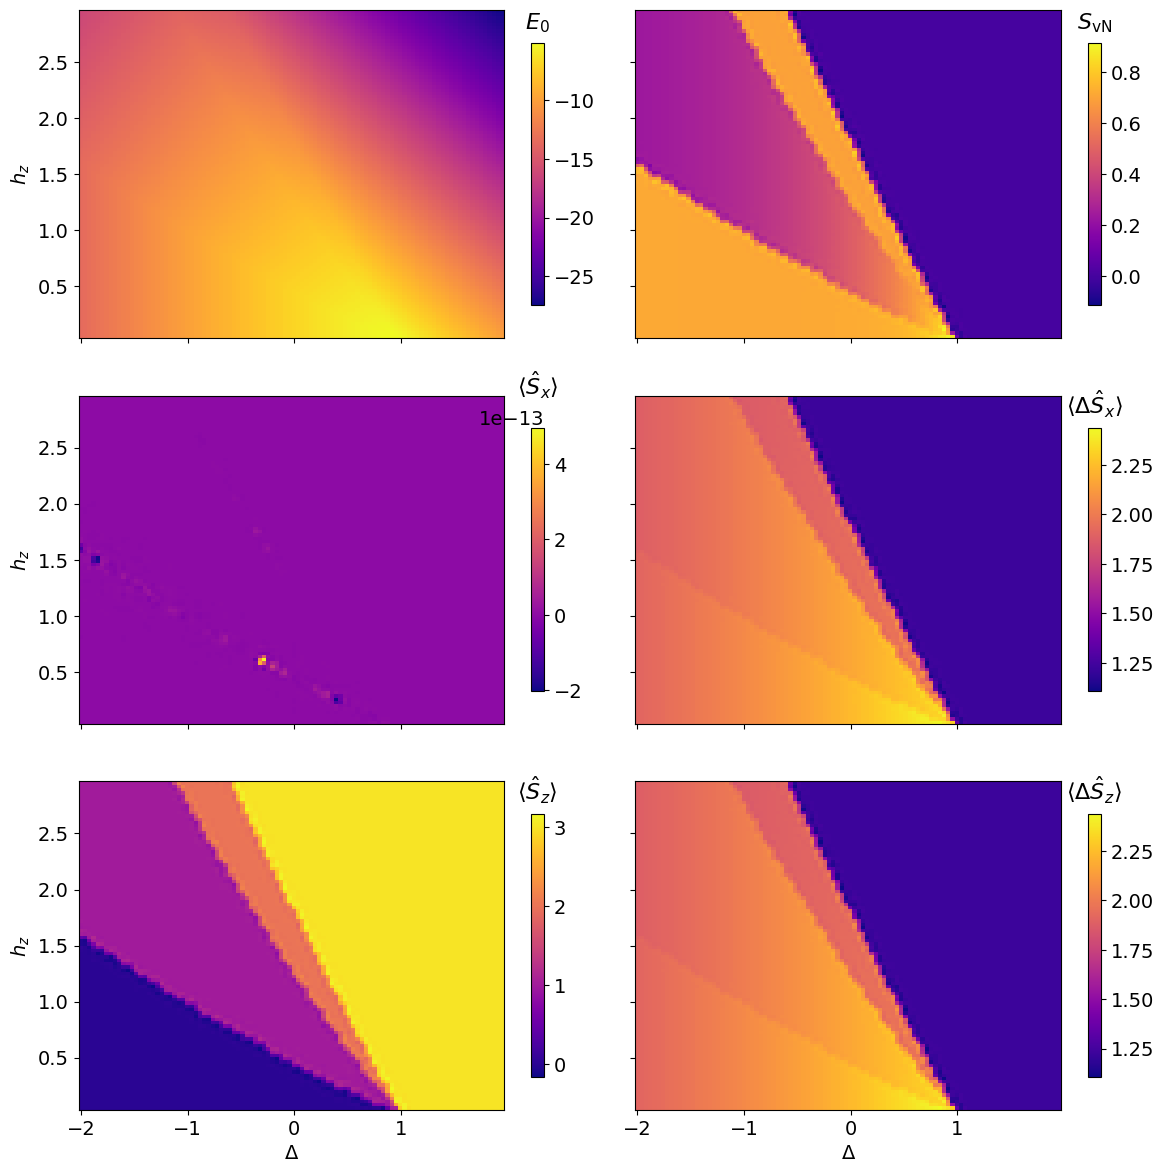

In [10]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey = True, sharex = True)

############
observable = 'E_0'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = axes[0, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=axes[0, 0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$E_0$", pad=10)  # Label on top of the colorbar
 
 
############
observable = 'SvN'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = axes[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=axes[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"$S_{\rm vN}$", pad=10)  # Label on top of the colorbar

############
observable = 'Sx'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\hat{S}_x\rangle$", pad=10)  # Label on top of the colorbar

############
observable = 'Sx_std'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\Delta\hat{S}_x\rangle$", pad=10)  # Label on top of the colorbar
 
############
observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar

############
observable = 'Sz_std'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\Delta\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar
 

axes[2,0].set_xlabel(r'$\Delta$')
axes[2,1].set_xlabel(r'$\Delta$')

axes[0,0].set_ylabel(r'$h_z$')
axes[1,0].set_ylabel(r'$h_z$')
axes[2,0].set_ylabel(r'$h_z$')


plt.tight_layout()
plt.savefig("fig0.png",dpi=600, format="png")
plt.show()

![](fig0.png)
As we can see, the density plot of $\langle\hat{S}_z\rangle$ or $S_{\rm vN}$ clearly show existence of distinct phases in the model, characterized by different entanglement properties.

### Unsupervised analysis

Let us performe unsupervised analysis of the ground state properties. We will check if Cholesky vectors $A_{vec}$ are indeed grouped in distinct clusters. We will perform PCA and t-SNE dimensionality reduction, projecting each Cholesky vector onto two-dimensional plane.

# PCA

Principal component analysis (PCA) is a dimensional reduction techique. Intuitively, the way it works is that we go from our original dataset

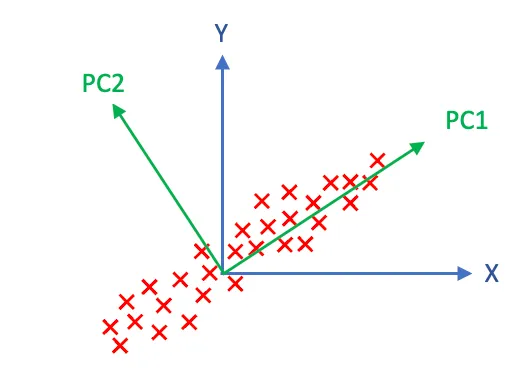

Into one described in a new coordinate system, such that most of the variance in the dataset can be explained with only a couple features. One of the most robust and elegant ways to perform PCA is by using the Singular Value Decomposition (SVD) of the data matrix. If we have a data matrix $X$ ("centralized"), the $SVD$ of $X$ is given by $X=U \Sigma V^{T}$

  In this decomposition, the columns of the matrix $V$ are the right singular vectors, which correspond directly to the principal components of the data. The singular values in the diagonal matrix $\Sigma$ are related to the standard deviations of the principal components, with larger singular values corresponding to components that capture more variance
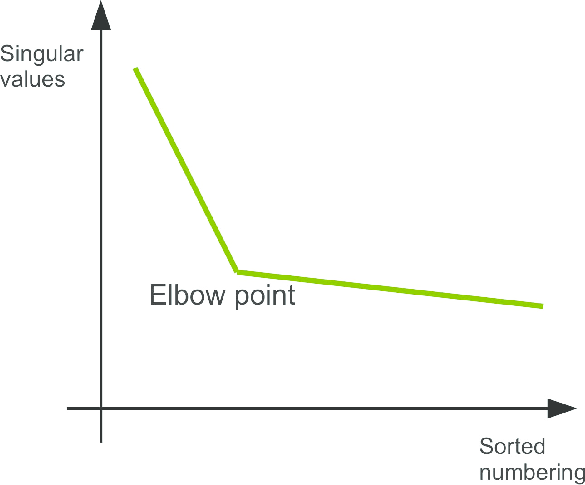

References:
1. The Elements of Statistical Learning by Hastie,Tibshirani and Friedman
2. The Scikit-learn documentation

## t-SNE

t-distributed stochastic neighbor embedding (t-SNE), is another dimensionality reduction technique,irst, it constructs a probability distribution over pairs of high-dimensional data points, where similar points have a higher probability of being neighbors according to 

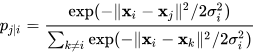

The Bandwidth of the Gaussian distributions $\sigma$ is given by the perplexity of the distribution (which we usually choose by hand). Then, it creates a similar probability distribution in the lower-dimensional space, but this time using a Student's t-distribution to model the distances. 

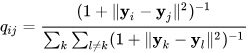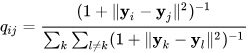

The points $y_{i}$ are found by minimizing the Kullback-Leibler Divergence

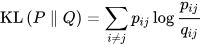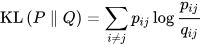

where 

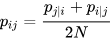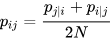

some references:

1. van der Maaten, L.J.P. t-Distributed Stochastic Neighbor Embedding
2. L.J.P. van der Maaten. Accelerating t-SNE using Tree-Based Algorithms.
3. The scikit-learn documentation

#### PCA and t-SNE on Cholesky vectors

In [11]:
all_vectors = np.stack(df_all['A_gs_vec'].values)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_vectors)

# Add PCA results to DataFrame
df_all['PCA1'] = reduced_data[:, 0]
df_all['PCA2'] = reduced_data[:, 1]

In [12]:
all_vectors = np.stack(df_all['A_gs_vec'].values)

perplexity_vec = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for perplexity in perplexity_vec:
    if not os.path.exists("fig1_perplexity.{:03d}_SvN_coloring.png".format(perplexity)):
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_data = tsne.fit_transform(all_vectors)
        
        # Add t-SNE results to DataFrame
        df_all['tSNE1'] = tsne_data[:, 0]
        df_all['tSNE2'] = tsne_data[:, 1]
        
        
        observable = 'Sz'  
        
        if(observable == 'Sz'):
            title_string = r"$\langle\hat{S}_z\rangle$"
        
        if(observable == 'Sx'):
            title_string = r"$\langle\hat{S}_x\rangle$"
        
        if(observable == 'Sx_std'):
            title_string = r"$\langle\Delta\hat{S}_x\rangle$"
        
        if(observable == 'Sz_std'):
            title_string = r"$\langle\Delta\hat{S}_z\rangle$"
        
        if(observable == 'SvN'):
            title_string = r"$S_{\rm vN}$"    
        
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        
        # Subplot 1: PCA scatter plot
        sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
        cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
        cbar1.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        axes[0].set_xlabel(r'$w_1$')
        axes[0].set_ylabel(r'$w_2$')
        axes[0].set_title('PCA')
        axes[0].grid(True)
        
        # Subplot 2: t-SNE scatter plot
        sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
        cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
        cbar2.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        
        
        axes[1].set_xlabel(r'$w_1$')
        # axes[1].set_ylabel(r'$w_2$')
        axes[1].set_title('t-SNE | perplexity : {:d}'.format(perplexity))
        axes[1].grid(True)
        
        # Subplot 3: Colormap
        
        x = df_all["delta"]
        y = df_all["hz"]
        z = df_all[observable]
        
        # Create a structured grid
        grid_x = np.linspace(x.min(), x.max(), 100)
        grid_y = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(grid_x, grid_y)
        
        # Interpolate z values onto the grid
        Z = griddata((x, y), z, (X, Y), method='cubic')
        
        
        im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
        cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
        cbar3.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        axes[2].set_xticks([-2, -1, 0, 1, 2])
        axes[2].set_xlabel(r'$\Delta$')
        axes[2].set_ylabel(r'$h_z$')
        
        plt.tight_layout()
        plt.savefig("fig1_perplexity.{:03d}_Sz_coloring.png".format(perplexity),dpi=600, format="png")
        plt.show()
        
        
        #############
        
        observable = 'SvN'
        if(observable == 'Sz'):
            title_string = r"$\langle\hat{S}_z\rangle$"
        
        if(observable == 'Sx'):
            title_string = r"$\langle\hat{S}_x\rangle$"
        
        if(observable == 'Sx_std'):
            title_string = r"$\langle\Delta\hat{S}_x\rangle$"
        
        if(observable == 'Sz_std'):
            title_string = r"$\langle\Delta\hat{S}_z\rangle$"
        
        if(observable == 'SvN'):
            title_string = r"$S_{\rm vN}$"    
        
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        
        # Subplot 1: PCA scatter plot
        sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
        cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
        cbar1.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        axes[0].set_xlabel(r'$w_1$')
        axes[0].set_ylabel(r'$w_2$')
        axes[0].set_title('PCA')
        axes[0].grid(True)
        
        # Subplot 2: t-SNE scatter plot
        sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
        cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
        cbar2.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        axes[1].set_xlabel(r'$w_1$')
        axes[1].set_title('t-SNE | perplexity : {:d}'.format(perplexity))
        axes[1].grid(True)
        
        # Subplot 3: Colormap
        
        x = df_all["delta"]
        y = df_all["hz"]
        z = df_all[observable]
        
        # Create a structured grid
        grid_x = np.linspace(x.min(), x.max(), 100)
        grid_y = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(grid_x, grid_y)
        
        # Interpolate z values onto the grid
        Z = griddata((x, y), z, (X, Y), method='cubic')
        
        
        im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
        cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
        cbar3.ax.set_title(title_string, pad=10)  # Label on top of the colorbar
        
        axes[2].set_xticks([-2, -1, 0, 1, 2])
        axes[2].set_xlabel(r'$\Delta$')
        axes[2].set_ylabel(r'$h_z$')
        
        plt.tight_layout()
        plt.savefig("fig1_perplexity.{:03d}_SvN_coloring.png".format(perplexity),dpi=600, format="png")
        plt.show()

As we can see, the linear PCA dimensionality reduction clearly projects density matrices (represented as Cholesky vectors) onto well separated clusters, where each cluster is characterized by value of $\langle\hat{S}_z\rangle$. We can also see clusterization with t-SNE approach. Color encoding of biparte entanglement entropy $S_{\rm vN}$, however, does not encodes clusters separately.
![](fig1_perplexity.100_Sz_coloring.png)
![](fig1_perplexity.100_SvN_coloring.png)

# Autoencoder

An autoencoder is a type of neural network used for unsupervised learning, designed to learn a compressed representation of data. It consists of two main parts: an encoder and a decoder. The encoder takes an input (like an image or a sentence) and compresses it into a smaller, dense representation called a bottleneck or latent space. This compressed representation captures the most essential features of the original data. 

### Unsupervised phase detection with reconstruction loss
Our aim is to train autoencoder (AE) transforming ground state Cholesky vector for given $\{\Delta, h_z\}$. Next, training AE on some randomly chosen set of parameters $\{\Delta, h_z\}$ having $M$ elements, we will plot reconstruction loss vs full range of $\{\Delta, h_z\}$. The main questions is: will we see 'phase boundaries' as on the $\langle\hat{S}_z\rangle$ phase diagram?

Let us start with defining training dataset

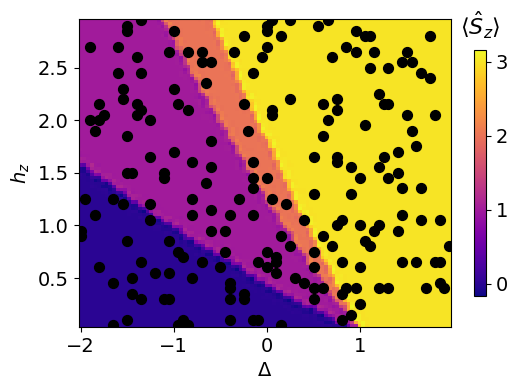

In [14]:
M = 200
df = df_all.sample(n = M, random_state=121)
X = np.stack(df['A_gs_vec'].values)
X_tensor = pt.tensor(X, dtype=pt.float32)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax.pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax, shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar


ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$h_z$')
ax.set_xticks([-2,-1,0,1,2])

ax.scatter(df["delta"], df["hz"], color="black", s=50)

plt.show()

### AE model definition
Let us build AE:
1. Encoder: linear layers : (input, hidden_layer_1, hidden_layer_2, bottleneck)
2. Decoder: linear layers : (bottleneck, hidden_layer_2, hidden_layer_1, output)

In [45]:
class Autoencoder(pt.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,   bottleneck_dim):
        """
        Autoencoder with configurable bottleneck size, two hidden layers, and dropout.

        Parameters:
        - input_dim: Number of input features
        - hidden_dim1: Size of the first hidden layer
        - hidden_dim2: Size of the second hidden layer
        - bottleneck_dim: Size of the bottleneck layer
        - dropout_prob: Dropout probability (default: 0.2)
        """
        super(Autoencoder, self).__init__()
        
        # Encoder: Two hidden layers + bottleneck
        self.encoder = pt.nn.Sequential(
            pt.nn.Linear(input_dim, hidden_dim1),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim1, hidden_dim2),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim2, bottleneck_dim),
            pt.nn.ReLU()
        )
        
        # Decoder: Reverse architecture of the encoder
        self.decoder = pt.nn.Sequential(
            pt.nn.Linear(bottleneck_dim, hidden_dim2),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim2, hidden_dim1),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim1, input_dim),
            pt.nn.ReLU()   
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [44]:
# Dynamically set input_dim based on data shape
input_dim = X_tensor.shape[1] 
hidden_dim1 = input_dim//2
hidden_dim2 = input_dim//3
bottleneck = input_dim//4
 

# Initialize model, loss, and optimizer
model = Autoencoder(input_dim, hidden_dim1, hidden_dim2, bottleneck)
criterion = pt.nn.MSELoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.0001)

# Print model structure for debugging
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4160, out_features=2080, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2080, out_features=1386, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1386, out_features=1040, bias=True)
    (7): LeakyReLU(negative_slope=0.3)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1040, out_features=1386, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1386, out_features=2080, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=2080, out_features=4160, bias=True)
    (7): LeakyReLU(negative_slope=0.3)
  )
)


In [16]:
# Training loop
epochs = 100
batch_size = X_tensor.shape[0]
dataset = pt.utils.data.TensorDataset(X_tensor)
dataloader = pt.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Training the autoencoder...")
for epoch in range(epochs):
    for batch in dataloader:
        inputs = batch[0]  # Get batch inputs
        
        # Ensure correct shape before forward pass
        if len(inputs.shape) == 1:  # If input is 1D, reshape to (1, num_features)
            inputs = inputs.unsqueeze(0)
        
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10==0):
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Training the autoencoder...
Epoch [1/100], Loss: 0.0003
Epoch [11/100], Loss: 0.0002
Epoch [21/100], Loss: 0.0002
Epoch [31/100], Loss: 0.0002
Epoch [41/100], Loss: 0.0002
Epoch [51/100], Loss: 0.0001
Epoch [61/100], Loss: 0.0001
Epoch [71/100], Loss: 0.0001
Epoch [81/100], Loss: 0.0001
Epoch [91/100], Loss: 0.0000


### Reconstruction loss phase diagram

Now, we will pass Cholesky vector $A_{vec}$ through trained AE for all range of parameters $\{\Delta, h_z\}$, obtaining $A_{vec, decoded}$. For each $\{\Delta, h_z\}$, we will:
1. Store reconstruction loss
2. Map $A_{vec, decoded}$ to proper density matrix $\hat{\rho}_{decoded}$
3. Calculate all observables for decoded density matrix $\hat{\rho}_{decoded}$

In [17]:
def get_SvN(rho):
    """ Calculate reduced density matrix rho_A = Tr_B[rho_AB]
        and its von Neuman entanglement entropy S_vN = -Tr[rho_A log[rho_A]]
    """
    rho_A = np.zeros((2**L_A, 2**L_A), dtype = np.complex128)
    for ket_v_A in fock_basis_A:
        idx_v_A = index_map_A[ket_v_A]
        for ket_w_A in fock_basis_A:
            idx_w_A = index_map_A[ket_w_A]
            for ket_v_B in fock_basis_B:
                ket_v_A_v_B = ket_v_A + ket_v_B
                ket_w_A_v_B = ket_w_A + ket_v_B
                
                idx_1 = index_map_AB[ket_v_A_v_B]
                idx_2 = index_map_AB[ket_w_A_v_B]
                
                rho_A[idx_v_A, idx_w_A] += rho[idx_1, idx_2]
                
    lambdas = np.linalg.eigvalsh(rho_A)
    SvN = 0
    epsilon = 1e-10
    for lambda_ in lambdas:
        SvN = SvN - lambda_*np.log(lambda_ + epsilon)
    return rho_A, SvN

In [18]:
# Set the model to evaluation mode
model.eval()
# Loss function
criterion = pt.nn.MSELoss()
 
# Iterate through each row in the DataFrame and calculate the loss
df_all_decoded = []
with pt.no_grad():  # Disable gradient calculation for evaluation
    for index, row in df_all.iterrows():
        # Extract 'A_gs_vec' and convert to PyTorch tensor
        A_gs_vec_true = pt.tensor(row['A_gs_vec'], dtype=pt.float32)        
        # Add batch dimension by unsqueezing
        A_gs_vec_true = A_gs_vec_true.unsqueeze(0)  # Shape becomes [1, num_features]        
        # Pass through the model
        A_gs_vec_decoded = model(A_gs_vec_true)        
        # Compute loss
        loss = criterion(A_gs_vec_decoded, A_gs_vec_true)         
        # Reconstruct density matrix rho from A_gs_vec_decoded
        # and calculate observables     
        A_gs_vec_decoded = A_gs_vec_decoded.squeeze(0).numpy()
        A_gs_decoded = cholesky_vector_to_cholesky_matrix(A_gs_vec_decoded)
        rho_gs_decoded = A_gs_decoded@A_gs_decoded.conj().T/np.trace(A_gs_decoded@A_gs_decoded.conj().T)    
        _, SvN_decoded = get_SvN(rho_gs_decoded)
        # Compute expectation values of total spin operators
        Sx_decoded = np.trace(Sx_total@rho_gs_decoded).real
        Sy_decoded = np.trace(Sy_total@rho_gs_decoded).real
        Sz_decoded = np.trace(Sz_total@rho_gs_decoded).real

        SxSx_decoded = np.trace(Sx_total@Sx_total@rho_gs_decoded).real
        SySy_decoded = np.trace(Sy_total@Sy_total@rho_gs_decoded).real
        SzSz_decoded = np.trace(Sz_total@Sx_total@rho_gs_decoded).real
        Sx_var_decoded = SxSx_decoded - Sx_decoded**2
        Sy_var_decoded = SySy_decoded - Sy_decoded**2
        Sz_var_decoded = SzSz_decoded - Sz_decoded**2
 
        row_decoded = row.to_dict()
        row_decoded['loss'] = loss
        row_decoded['A_gs_vec_decoded'] = A_gs_vec_decoded,
        row_decoded['SvN_decoded'] = SvN_decoded
        row_decoded['Sx_decoded']  = Sx_decoded
        row_decoded['Sy_decoded']  = Sy_decoded
        row_decoded['Sz_decoded']  = Sz_decoded
        
        row_decoded['Sx_var_decoded']  = Sx_var_decoded
        row_decoded['Sy_var_decoded']  = Sy_var_decoded
        row_decoded['Sz_var_decoded']  = Sz_var_decoded
 
        df_all_decoded.append(row_decoded)

df_all_decoded = pd.DataFrame(df_all_decoded)
print("Done ...")

Done ...


# Reconstruction loss phase diagram

Finally, we can plot reconstruction loss phase diagram, and see expectation values of observables on decoded density matrix

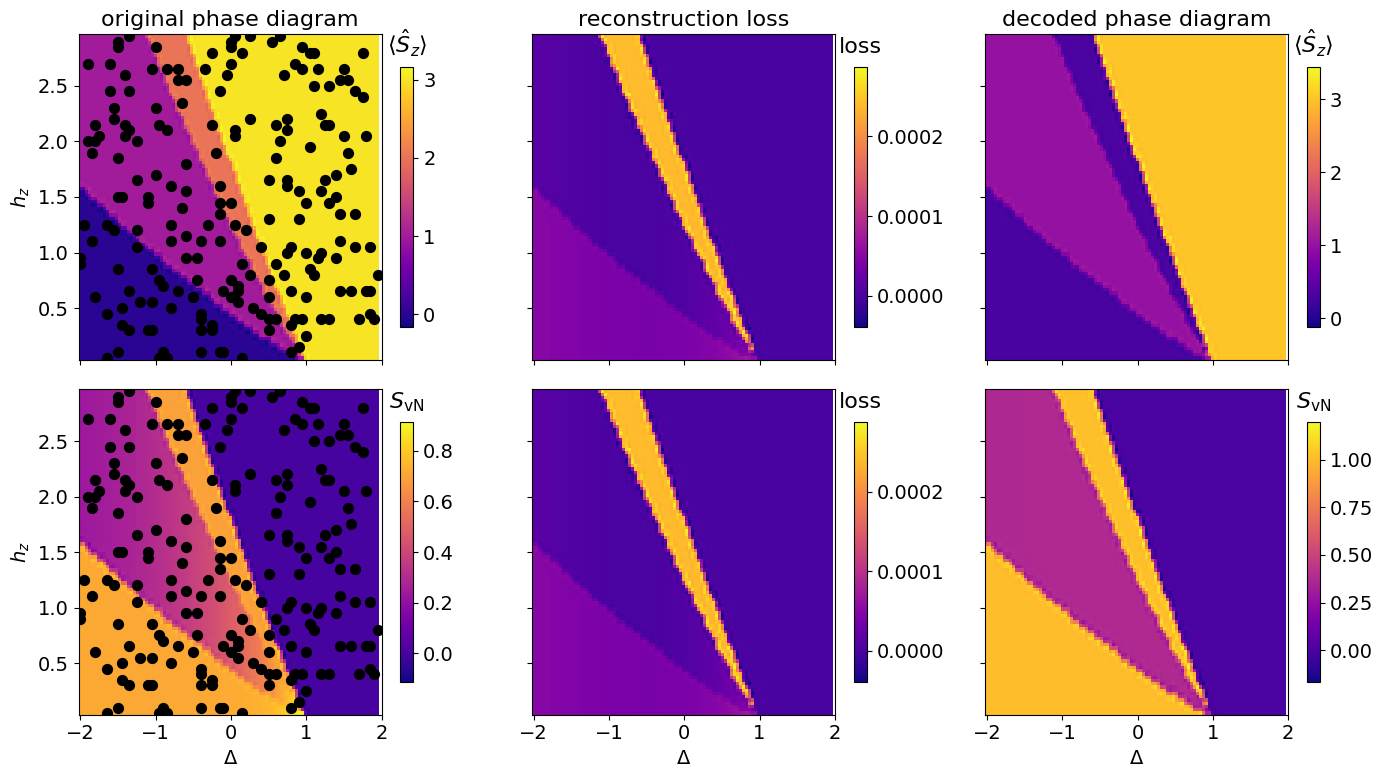

In [19]:
cmap_string = 'plasma'
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharey = True, sharex = True)

observable = 'Sz'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax[0,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax[0,0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar
 
# Plot the third heatmap (using the same data for demonstration)
observable = 'loss'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"loss", pad=10)  # Label on top of the colorbar
 


# Plot the third heatmap (using the same data for demonstration)
observable = 'Sz_decoded'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar


observable = 'SvN'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax[1,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax[1,0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$S_{\rm vN}$", pad=10)  # Label on top of the colorbar
 
# Plot the third heatmap (using the same data for demonstration)
observable = 'loss'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"loss", pad=10)  # Label on top of the colorbar

observable = 'SvN_decoded'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"$S_{\rm vN}$", pad=10)  # Label on top of the colorbar

ax[0,0].set_title("original phase diagram")
ax[0,1].set_title("reconstruction loss")
ax[0,2].set_title("decoded phase diagram")
ax[1,0].set_xlabel(r'$\Delta$')
ax[1,1].set_xlabel(r'$\Delta$')
ax[1,2].set_xlabel(r'$\Delta$')

ax[0,0].set_ylabel(r'$h_z$')
ax[1,0].set_ylabel(r'$h_z$')
ax[1,1].set_xticks([-2, -1, 0, 1, 2])


ax[0,0].scatter(df["delta"], df["hz"], color="black", s=50)
ax[1,0].scatter(df["delta"], df["hz"], color="black", s=50)

ax[1,0].set_xticks([-2, -1, 0, 1, 2])

plt.tight_layout()
plt.savefig("phase_diagram_reconstruction_loss.png", dpi=100, format="png")


plt.show()

### Results
As we can see, reconstruction loss is able to indicate possible boundaries on phase diagram. The reconstructed density matrices on parameters outside of the training range have values close to the true one.

![image](phase_diagram_reconstruction_loss.png)


### Tasks:
1. Consider training data from a given magnetization sector:

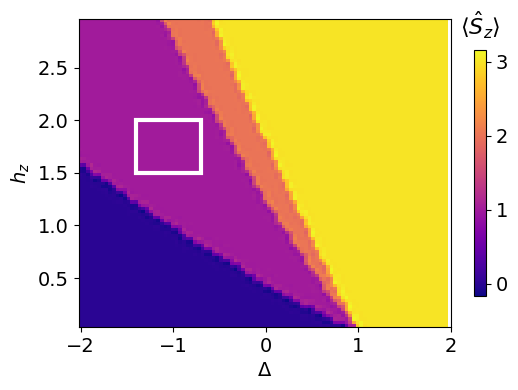

In [20]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

delta_min = -1.4   # define range of parameters for training autoencoder
delta_max = -0.7   # define range of parameters for training autoencoder
hz_min = 1.5     # define range of parameters for training autoencoder
hz_max = 2     # define range of parameters for training autoencoder
 
x = delta_min               # Bottom-left corner x-coordinate
y = hz_min                  # Bottom-left corner y-coordinate
width = delta_max - delta_min  # Width of the rectangle
height = hz_max - hz_min       # Height of the rectangle
# Create the rectangle patch
rect = Rectangle((x, y), width, height, edgecolor='white', facecolor='none', linewidth=3)


observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]


grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax.pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax, shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar

ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$h_z$')
ax.set_xticks([-2,-1,0,1,2])
ax.add_patch(rect)
plt.show()

### Thermal phase diagram of the XXZ model
In this tutorial we will study, within the Exact Diagonalization approach, the Gibbs states the Heisenberg XXZ model in a transverse field. The thermal (Gibbs state) is defined as
\begin{equation}
\begin{split}\
\hat{\rho}_T &= \frac{e^{-\hat{H}/T}}{{\cal Z}} = \frac{1}{{\cal Z}} \sum_i e^{-E_i/T}|E_i\rangle\langle E_i|,\\
{\cal Z} & = \sum_i e^{-E_i/T},
\end{split}
\end{equation}
where
\begin{equation}
\hat{H}  = \sum_i E_i |E_i\rangle\langle E_i|
\end{equation}

Our aim it to study $\{\Delta, h_z\}$ phase diagram at finite temperature $T$.
We will:
1. Construct the Hamiltonian for $L$ spins.
2. Perform exact diagonalization and prepare finite temperature Gibbs states of the system.
3. Calculate entanglement entropy and analyze system properties.
4. Visualize the results.
5. We will study quantum distance between $\hat{\rho}_T$ and its reconstruction $\hat{\rho}_{T, pred}$ with trace distance. Trace distance between two density matrices is as
\begin{equation}
\begin{split}
d(\hat{\rho}_1, \hat{\rho}_2) &= \frac{1}{2}Tr(\hat{\delta}^\dagger\hat{\delta}),\\
\hat{\delta} &= \hat{\rho}_1 - \hat{\rho}_2
\end{split}
\end{equation}


The goal is to analyze ground state properties of the model for small system size $L$.

We need to start with definitions of many-body operators acting on $L$ spins-$1/2$ chain.


## A side note for physicist

The Equilibrium state of a quantum system in an environment is actually given by
\begin{equation}
\begin{split}\
\hat{\rho}_{EQ} &= \frac{e^{-\hat{H}_{MF}/T}}{{\cal Z}} 
\end{split}
\end{equation}


where $\hat{H_{MF}}$ is what is known as the Mean Force Hamiltonian, you can think of it as adding a correction to the Hamiltonian (Some times called dressing)

$$\hat{H}_{MF}=\hat{H} + \hat{H}_{correction} $$

its form depends on the spectral signatures of the environment. For those interested you can see these references:

1. [Open quantum system dynamics and the mean force Gibbs state. AVS Quantum Sci. 012301](https://doi.org/10.1116/5.0073853)
2. [Corrections to the Hamiltonian induced by finite-strength coupling to the environment Phys. Rev. E, 110, 014144.](https://doi.org/10.1103/PhysRevE.110.014144)

In [36]:
def get_Gibbs_state(H, T):
    """
    Construct the Gibbs state for the Hamiltonian H at finite temperature T

    Args:
        H (array): Hamiltonian
        T (float): Gibbs state temperature

    Returns:
        np.ndarray: The Gibbs state.
    """
    if T < 0:
        raise ValueError("Temperature T must be greater than zero.")
    E, P = np.linalg.eigh(H) 
    if(T == 0):
        Gibbs_weights = np.zeros((H.shape[0]))
        Gibbs_weights[0] = 1        
        Z = np.sum(Gibbs_weights)
        rho_T_eigenbasis = np.diag(Gibbs_weights)/Z
        
    if(T>0):
        Gibbs_weights = np.exp(-E/T)
        Z = np.sum(Gibbs_weights)
        rho_T_eigenbasis = np.diag(Gibbs_weights)/Z
  
    rho_T = P @ rho_T_eigenbasis @ P.conj().T
    return rho_T_eigenbasis, rho_T

Let's check Gibbs state construction

In [46]:
H = np.array([[1, 0.5, 3], [0.5, 2, 3], [1, 2, 3]])
H = H+H.T
# Temperature for the Gibbs state
T = 0

# Compute Gibbs state
rho_T_eigenbasis, rho_T = get_Gibbs_state(H, T)

print("Gibbs state in H eigenbasis")
print(rho_T_eigenbasis)

print("Gibbs state in Pauli-Z eigenbasis")
print(rho_T)

print("\nTrace of rho_T:", np.trace(rho_T).real)
print("Hermitian check (rho_T == rho_T^dagger):", np.allclose(rho_T, rho_T.conj().T))

Gibbs state in H eigenbasis
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Gibbs state in Pauli-Z eigenbasis
[[ 0.36240379  0.28657408 -0.3859308 ]
 [ 0.28657408  0.22661105 -0.30517827]
 [-0.3859308  -0.30517827  0.41098516]]

Trace of rho_T: 0.9999999999999999
Hermitian check (rho_T == rho_T^dagger): True


In [23]:

def hilbert_schmidt_distance(rho1, rho2):
    """
    Calculate the Hilbert-Schmidt distance between two density matrices.

    Parameters:
        rho1 (numpy.ndarray): First density matrix.
        rho2 (numpy.ndarray): Second density matrix.

    Returns:
        float: The Hilbert-Schmidt distance.
    """
    # Ensure rho1 and rho2 are NumPy arrays
    rho1 = np.array(rho1)
    rho2 = np.array(rho2)
    # Compute the difference between the density matrices
    delta = rho1 - rho2
    # Compute the Hilbert-Schmidt distance
    distance = np.sqrt(np.trace(delta @ delta.conj().T).real)
    return distance

def trace_distance(rho_1, rho_2):
    delta = rho_1 - rho_2
    rank = np.linalg.matrix_rank(delta)
    evals = np.linalg.eigvalsh(delta)
    d = 0
    for i in range(rank):
        d += np.abs(evals[i])
    return d/2

def get_distance(rho_1, rho_2):
    return hilbert_schmidt_distance(rho_1, rho_2)

def get_observable_string(observable):
    title_string = observable
    if(observable == 'E_0'):
        title_string = r"$E_0$"
        
    if(observable == 'Sz' or observable == 'Sz_decoded'):
        title_string = r"$\langle\hat{S}_z\rangle$"
    
    if(observable == 'Sx' or observable == 'Sx_decoded'):
        title_string = r"$\langle\hat{S}_x\rangle$"
    
    if(observable == 'Sx_var' or observable == 'Sx_var_decoded'):
        title_string = r"$\langle\Delta^2\hat{S}_x\rangle$"
    
    if(observable == 'Sz_var' or observable == 'Sz_var_decoded'):
        title_string = r"$\langle\Delta^2\hat{S}_z\rangle$"
    
    if(observable == 'SvN' or observable == 'SvN_decoded'):
        title_string = r"$S_{\rm vN}$"
    return title_string

We repeat the main simulation with a Gibbs state

In [24]:
L_values = [6]

delta_values = np.arange(-1, 1, 0.025)
hz_values = np.arange(0, 3, 0.025)


T_values = np.array([0.5])

for L in L_values:
    data = []
    dim = 2**L
    
    L_A = L//2
    L_B = L - L_A
    fock_basis_AB, index_map_AB = generate_fock_basis(L)
    fock_basis_A, index_map_A  = generate_fock_basis(L_A)
    fock_basis_B, index_map_B = generate_fock_basis(L_B)
    
    
    Sx_total = total_sigma_operator(L, sigma_x)/2.0 #we divide by 2 to have proper spin-chain operators
    Sy_total = total_sigma_operator(L, sigma_y)/2.0 #we divide by 2 to have proper spin-chain operators
    Sz_total = total_sigma_operator(L, sigma_z)/2.0 #we divide by 2 to have proper spin-chain operators
   
    
    for delta in tqdm(delta_values):
        for hz in hz_values:
            if(delta !=0 and hz !=0): 
                for T in T_values:         
                    H = xxz_hamiltonian(L, delta, hz)
                    rho_eigenbasis, rho = get_Gibbs_state(H, T)
               
                    epsilon = 1e-1
                    rho = (1-epsilon)*rho + epsilon*np.eye(dim)/dim
                    _, SvN = get_SvN(rho)
            
                    A = cholesky(rho, lower=True)
                    A_vec = cholesky_matrix_to_cholesky_vector(A)
            
                    # Compute expectation values of total spin operators
                    E = np.trace(H @ rho).real
                    Sx = np.trace(Sx_total @ rho).real
                    Sy = np.trace(Sy_total @ rho).real
                    Sz = np.trace(Sz_total @ rho).real
                    
                    Sx_var = np.trace(Sx_total @ Sx_total @ rho).real - Sx**2
                    Sy_var = np.trace(Sy_total @ Sy_total @ rho).real - Sy**2
                    Sz_var = np.trace(Sz_total @ Sz_total @ rho).real - Sz**2
  
                    data.append({
                        "L"         : L,
                        "delta"     : delta,
                        "hz"        : hz,
                        "T"         : T, 
                        "SvN"       : SvN,
                        "E"         : E,
                        "Sx"        : Sx,
                        "Sy"        : Sy,
                        "Sz"        : Sz,
                        "Sx_var"    : Sx_var,
                        "Sy_var"    : Sx_var,
                        "Sz_var"    : Sx_var,
                        "A_vec"     : A_vec,
                    })
    df_all = pd.DataFrame(data)   
    df_all.to_pickle("./data_XXZ_thermal_state_properties_L." + "{:02d}".format(L) + ".pkl")

100%|███████████████████████████████████████████████████████████████████████████████████████| 80/80 [34:50<00:00, 26.14s/it]


### Phases of the model

Let us have a look at properties of the system as a function of $\Delta$ and $h_z$. The easiest step will be to look at density plots of:
1. Ground state energy $E_0$
2. von Neuman entanglement entropy $S_{\rm vN}$
3. Expectation value $\langle\hat{S}_x\rangle$ and its variance deviation $\langle\Delta^2 \hat{S}_x\rangle = \langle\hat{S}^2_x\rangle - \langle\hat{S}_x\rangle^2$
4. Expectation value $\langle\hat{S}_z\rangle$ and its standard deviation $\langle\Delta^2 \hat{S}_z\rangle = \langle\hat{S}^2_z\rangle - \langle\hat{S}_z\rangle^2$ 

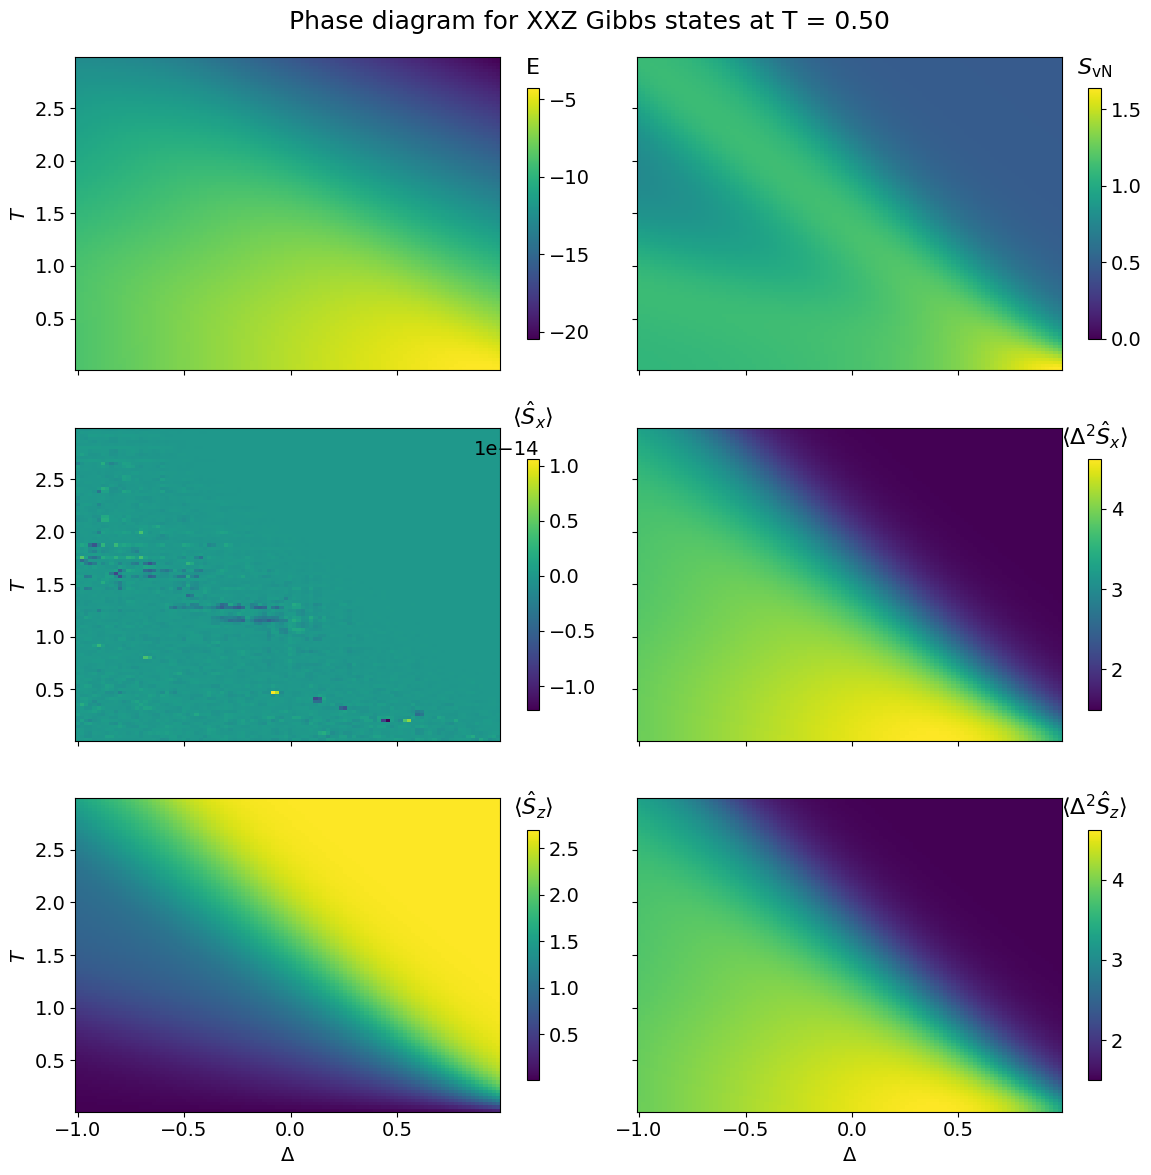

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey = True, sharex = True)
cmap_string = 'viridis'
fig.suptitle("Phase diagram for XXZ Gibbs states at T = {:2.2f}".format(T))
############
observable = 'E'
x = df_all["delta"]
y = df_all["hz"]
z = df_all['E']
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = axes[0, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=axes[0, 0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
 
 
############
observable = 'SvN'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = axes[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, vmin = 0, vmax = max(z), shading='auto')
cbar3 = fig.colorbar(im3, ax=axes[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar

############
observable = 'Sx'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar

############
observable = 'Sx_var'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
 
############
observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar

############
observable = 'Sz_var'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
 

axes[2,0].set_xlabel(r'$\Delta$')
axes[2,1].set_xlabel(r'$\Delta$')

axes[0,0].set_ylabel(r'$T$')
axes[1,0].set_ylabel(r'$T$')
axes[2,0].set_ylabel(r'$T$')


plt.tight_layout()
plt.savefig("fig0_thermal.png",dpi=600, format="png")
plt.show()

As we can see, the density plot of $\langle\hat{S}_z\rangle$ or $S_{\rm vN}$ clearly show existence of distinct phases in the model, characterized by different entanglement properties.
![image](fig0_thermal.png)

### Unsupervised analysis

Let us perform unsupervised analysis of the ground state properties. We will check if Cholesky vectors $A_{vec}$ are indeed grouped in distinct clusters. We will perform PCA and t-SNE dimensionality reduction, projecting each Cholesky vector onto two-dimensional plane.

#### PCA and t-SNE on Cholesky vectors

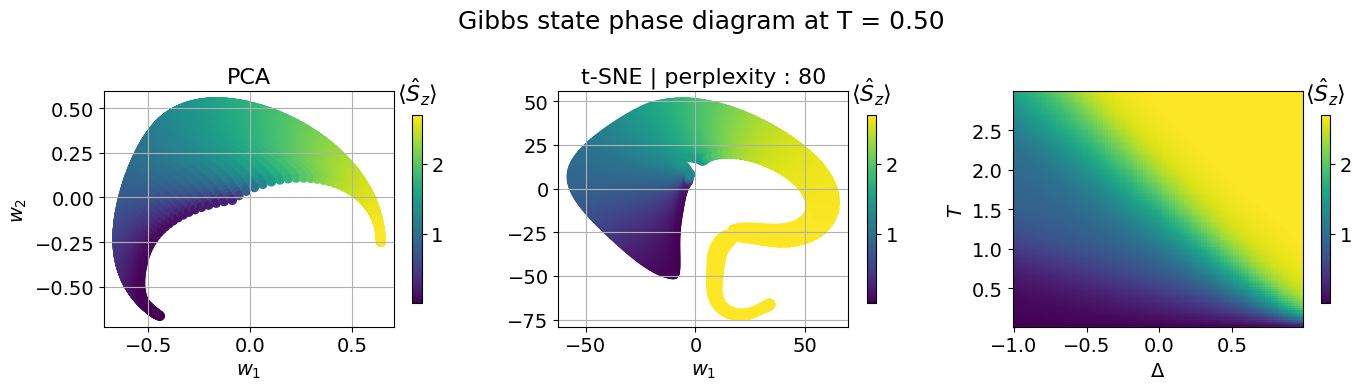

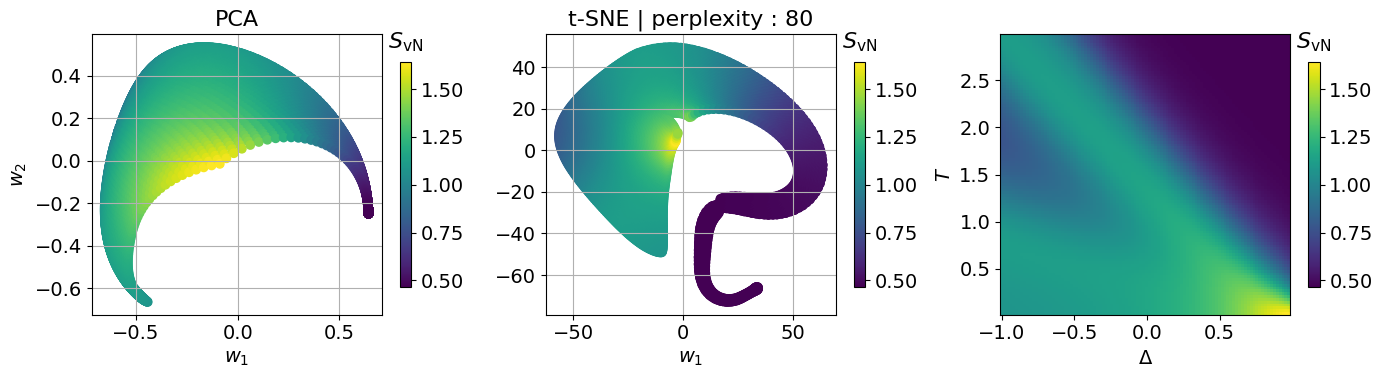

In [26]:
all_vectors = np.stack(df_all['A_vec'].values)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_vectors)

# Add PCA results to DataFrame
df_all['PCA1'] = reduced_data[:, 0]
df_all['PCA2'] = reduced_data[:, 1]
all_vectors = np.stack(df_all['A_vec'].values)

#perplexity_vec = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perplexity_vec = [80]
for perplexity in perplexity_vec:
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_data = tsne.fit_transform(all_vectors)
    
    # Add t-SNE results to DataFrame
    df_all['tSNE1'] = tsne_data[:, 0]
    df_all['tSNE2'] = tsne_data[:, 1]
    
    
    observable = 'Sz'  
  
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("Gibbs state phase diagram at T = {:2.2f}".format(T))
    # Subplot 1: PCA scatter plot
    sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
    cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
    cbar1.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    axes[0].set_xlabel(r'$w_1$')
    axes[0].set_ylabel(r'$w_2$')
    axes[0].set_title('PCA')
    axes[0].grid(True)
    
    # Subplot 2: t-SNE scatter plot
    sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
    cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
    cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    axes[1].set_xlabel(r'$w_1$')
    axes[1].set_title('t-SNE | perplexity : {:d}'.format(perplexity))
    axes[1].grid(True)
    
    # Subplot 3: Colormap
    
    x = df_all["delta"]
    y = df_all["hz"]
    z = df_all[observable]
    
    # Create a structured grid
    grid_x = np.linspace(x.min(), x.max(), 100)
    grid_y = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(grid_x, grid_y)
    
    # Interpolate z values onto the grid
    Z = griddata((x, y), z, (X, Y), method='cubic')
    
    
    im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
    cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
    cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    #axes[2].set_xticks([-2, -1, 0, 1, 2])
    axes[2].set_xlabel(r'$\Delta$')
    axes[2].set_ylabel(r'$T$')
    
    plt.tight_layout()
    plt.savefig("fig1_perplexity.{:03d}_Sz_coloring_thermal.png".format(perplexity),dpi=600, format="png")
    plt.show()
    
    
    #############
    
    observable = 'SvN'
  
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Subplot 1: PCA scatter plot
    sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
    cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
    cbar1.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    axes[0].set_xlabel(r'$w_1$')
    axes[0].set_ylabel(r'$w_2$')
    axes[0].set_title('PCA')
    axes[0].grid(True)
    
    # Subplot 2: t-SNE scatter plot
    sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
    cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
    cbar2.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    axes[1].set_xlabel(r'$w_1$')
    axes[1].set_title('t-SNE | perplexity : {:d}'.format(perplexity))
    axes[1].grid(True)
    
    # Subplot 3: Colormap
    
    x = df_all["delta"]
    y = df_all["hz"]
    z = df_all[observable]
    
    # Create a structured grid
    grid_x = np.linspace(x.min(), x.max(), 100)
    grid_y = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(grid_x, grid_y)
    
    # Interpolate z values onto the grid
    Z = griddata((x, y), z, (X, Y), method='cubic')
    
    
    im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
    cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
    cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
    
    #axes[2].set_xticks([-2, -1, 0, 1, 2])
    axes[2].set_xlabel(r'$\Delta$')
    axes[2].set_ylabel(r'$T$')
    
    plt.tight_layout()
    plt.savefig("fig1_perplexity.{:03d}_SvN_coloring_thermal.png".format(perplexity),dpi=600, format="png")
    plt.show()

![](fig1_perplexity.080_SvN_coloring.png)
As we can see, the linear PCA dimensionality reduction clearly projects density matrices (represented as Cholesky vectors) onto well separated clusters, where each cluster is characterized by value of $\langle\hat{S}_z\rangle$. We can also see clusterization with t-SNE approach. Color encoding of biparte entanglement entropy $S_{\rm vN}$, however, does not encodes clusters separately.

# Autoencoder
### Unsupervised phase detection with reconstruction loss
Our aim is to train autoencoder (AE) transforming ground state Cholesky vector for given $\{\Delta, h_z\}$. Next, training AE on some randomly chosen set of parameters $\{\Delta, h_z\}$ having $M$ elements, we will plot reconstruction loss vs full range of $\{\Delta, h_z\}$. The main questions is: will we see 'phase boundaries' as on the $\langle\hat{S}_z\rangle$ phase diagram? How the reconstruction depends on temperature $T$?
Let us start with defining training dataset

In [27]:
M = 10
df = df_all.sample(n = M, random_state=121)
X = np.stack(df['A_vec'].values)
X_tensor = pt.tensor(X, dtype=pt.float32)

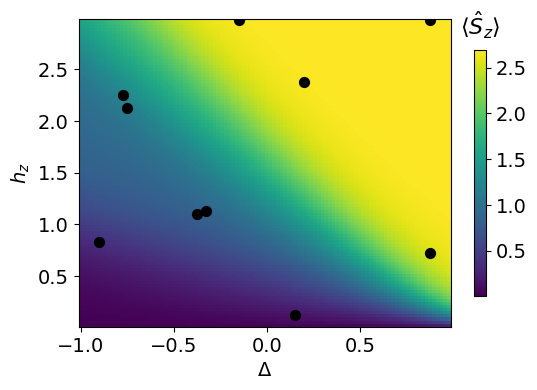

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax.pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax, shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar


ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$h_z$')
 
ax.scatter(df["delta"], df["hz"], color="black", s=50)

plt.show()

### AE model definition
Let us build AE:
1. Encoder: linear layers : (input, hidden_layer_1, hidden_layer_2, bottleneck)
2. Decoder: linear layers : (bottleneck, hidden_layer_2, hidden_layer_1, output)

In [29]:
class Autoencoder(pt.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,   bottleneck_dim):
        """
        Autoencoder with configurable bottleneck size, two hidden layers, and dropout.

        Parameters:
        - input_dim: Number of input features
        - hidden_dim1: Size of the first hidden layer
        - hidden_dim2: Size of the second hidden layer
        - bottleneck_dim: Size of the bottleneck layer
        - dropout_prob: Dropout probability (default: 0.2)
        """
        super(Autoencoder, self).__init__()
        
        # Encoder: Two hidden layers + bottleneck
        self.encoder = pt.nn.Sequential(
            pt.nn.Linear(input_dim, hidden_dim1),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim1, hidden_dim2),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim2, bottleneck_dim),
            pt.nn.LeakyReLU(0.3)
        )
        
        # Decoder: Reverse architecture of the encoder
        self.decoder = pt.nn.Sequential(
            pt.nn.Linear(bottleneck_dim, hidden_dim2),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim2, hidden_dim1),
            pt.nn.ReLU(),
            pt.nn.Dropout(0.2),
            pt.nn.Linear(hidden_dim1, input_dim), 
            pt.nn.LeakyReLU(0.3)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Dynamically set input_dim based on data shape
input_dim = X_tensor.shape[1] 
hidden_dim1 = input_dim//2
hidden_dim2 = input_dim//3
bottleneck = input_dim//4

In [30]:
# Initialize model, loss, and optimizer
model = Autoencoder(input_dim, hidden_dim1, hidden_dim2, bottleneck)
criterion = pt.nn.MSELoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.0001)

# Print model structure for debugging
print(model)

# Training loop
epochs = 100
batch_size = 128
dataset = pt.utils.data.TensorDataset(X_tensor)
dataloader = pt.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Training the autoencoder...")
for epoch in range(epochs):
    for batch in dataloader:
        inputs = batch[0]  # Get batch inputs
        
        # Ensure correct shape before forward pass
        if len(inputs.shape) == 1:  # If input is 1D, reshape to (1, num_features)
            inputs = inputs.unsqueeze(0)
        
        latent, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10==0):
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4160, out_features=2080, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2080, out_features=1386, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1386, out_features=1040, bias=True)
    (7): LeakyReLU(negative_slope=0.3)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1040, out_features=1386, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1386, out_features=2080, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=2080, out_features=4160, bias=True)
    (7): LeakyReLU(negative_slope=0.3)
  )
)
Training the autoencoder...
Epoch [1/100], Loss: 0.0003
Epoch [11/100], Loss: 0.0002
Epoch [21/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0001
Epoch [41/100], Loss: 0.0001
Epoch [51/100], Loss: 0.0001
Epoch [61/100], Loss: 0.0001
Epoch [71/100],

### Reconstruction loss phase diagram

Now, we will pass Cholesky vector $A_{vec}$ through trained AE for all range of parameters $\{\Delta, h_z\}$, obtaining $A_{vec, decoded}$. For each $\{\Delta, h_z\}$, we will:
1. Store reconstruction loss
2. Map $A_{vec, decoded}$ to proper density matrix $\hat{\rho}_{decoded}$
3. Calculate all observables for decoded density matrix $\hat{\rho}_{decoded}$

In [31]:
# Update loss criterion to output per-sample loss
criterion = pt.nn.MSELoss(reduction='none')

batch_size = 64
df_all_decoded = []

with pt.no_grad():
    for start_idx in range(0, len(df_all), batch_size):
        batch = df_all.iloc[start_idx:start_idx + batch_size]
        A_vec_true = pt.tensor(np.stack(batch['A_vec']), dtype=pt.float32)

        # Pass batch through the model
        A_vec_latent, A_vec_decoded = model(A_vec_true)

        # Compute per-sample losses
        loss_per_sample = criterion(A_vec_decoded, A_vec_true).mean(dim=1)

        # Post-process each sample in the batch
        for idx, (vec_decoded, vec_latent, true_loss) in enumerate(
            zip(A_vec_decoded, A_vec_latent, loss_per_sample)
        ):
            vec_decoded_np = vec_decoded.numpy()
            A_decoded = cholesky_vector_to_cholesky_matrix(vec_decoded_np)
            rho_decoded = A_decoded @ A_decoded.conj().T / np.trace(A_decoded @ A_decoded.conj().T)
            _, SvN_decoded = get_SvN(rho_decoded)

            # Compute observables
            Sx_decoded = np.trace(Sx_total @ rho_decoded).real
            Sy_decoded = np.trace(Sy_total @ rho_decoded).real
            Sz_decoded = np.trace(Sz_total @ rho_decoded).real
            Sx_var_decoded = np.trace(Sx_total @ Sx_total @ rho_decoded).real - Sx_decoded**2
            Sy_var_decoded = np.trace(Sy_total @ Sy_total @ rho_decoded).real - Sy_decoded**2
            Sz_var_decoded = np.trace(Sz_total @ Sz_total @ rho_decoded).real - Sz_decoded**2


            tr_distance = trace_distance(rho, rho_decoded)
            hs_distance = hilbert_schmidt_distance(rho, rho_decoded)

            row_decoded = batch.iloc[idx].to_dict()
            row_decoded.update({
                'loss': true_loss.item(),
                'A_vec_decoded'    : vec_decoded_np,
                'A_vec_latent'     : vec_latent.numpy(),
                'SvN_decoded'      : SvN_decoded,
                'Sx_decoded'       : Sx_decoded,
                'Sy_decoded'       : Sy_decoded,
                'Sz_decoded'       : Sz_decoded,
                'Sx_var_decoded'   : Sx_var_decoded,
                'Sy_var_decoded'   : Sy_var_decoded,
                'Sz_var_decoded'   : Sz_var_decoded,
                'tr_distance'      : tr_distance,
                'hs_distance'      : hs_distance,
            })
            df_all_decoded.append(row_decoded)

df_all_decoded = pd.DataFrame(df_all_decoded)
print("Done ...")

Done ...


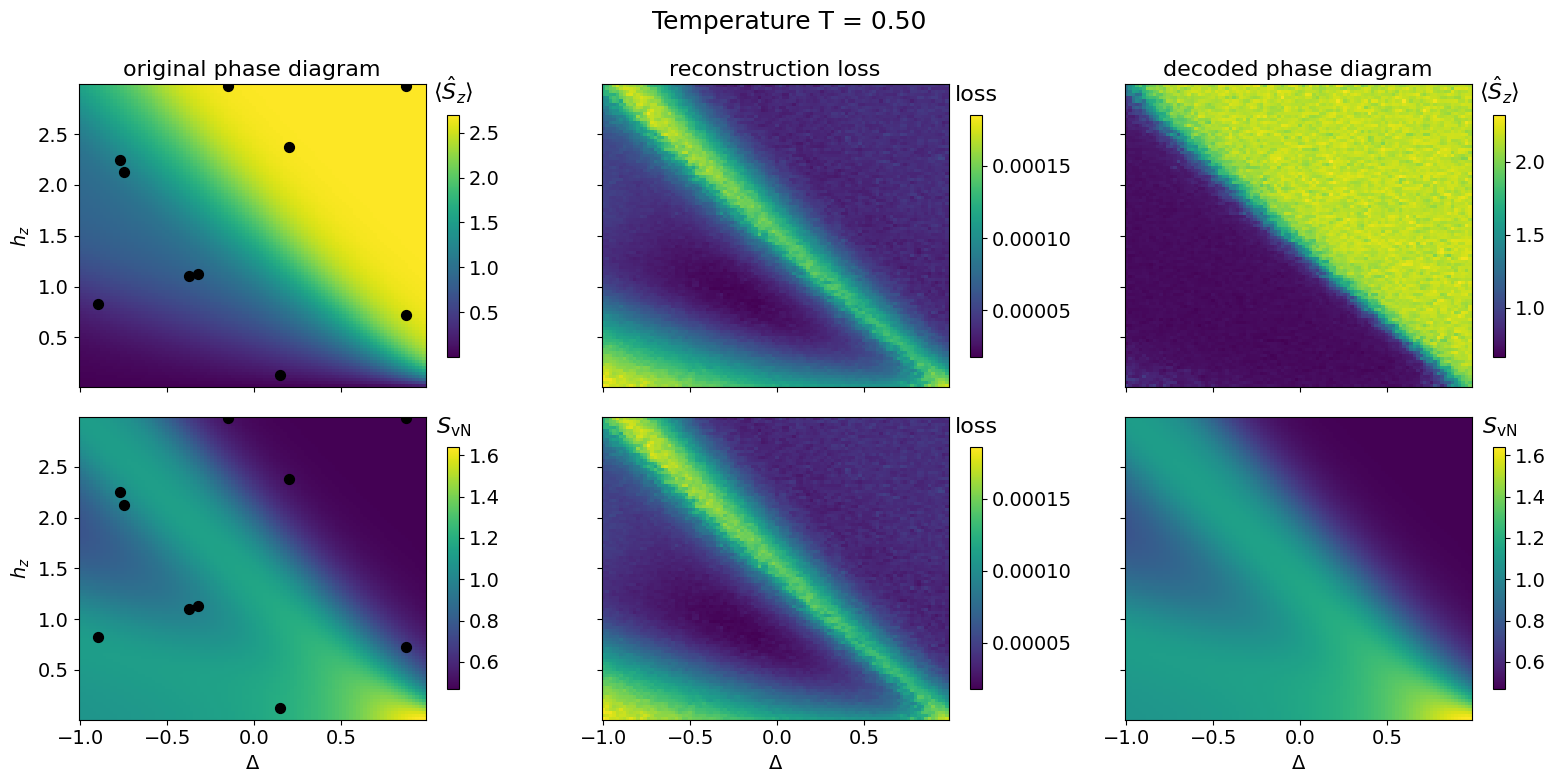

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharey = True, sharex = True)
fig.suptitle("Temperature T = {:2.2f}".format(T))
observable = 'Sz'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax[0,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax[0,0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar
 
# Plot the third heatmap (using the same data for demonstration)
observable = 'loss'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"loss", pad=10)  # Label on top of the colorbar
 
# Plot the third heatmap (using the same data for demonstration)
observable = 'Sz_decoded'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar

observable = 'SvN'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = ax[1,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=ax[1,0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
 
# Plot the third heatmap (using the same data for demonstration)
observable = 'loss'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"loss", pad=10)  # Label on top of the colorbar

observable = 'SvN_decoded'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded['SvN']
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar

ax[0,0].set_title("original phase diagram".format(T))
ax[0,1].set_title("reconstruction loss")
ax[0,2].set_title("decoded phase diagram")
ax[1,0].set_xlabel(r'$\Delta$')
ax[1,1].set_xlabel(r'$\Delta$')
ax[1,2].set_xlabel(r'$\Delta$')
 
ax[0,0].set_ylabel(r'$h_z$')
ax[1,0].set_ylabel(r'$h_z$')
 
ax[0,0].scatter(df["delta"], df["hz"], color="black", s=50)
ax[1,0].scatter(df["delta"], df["hz"], color="black", s=50)

plt.tight_layout()
plt.savefig("phase_diagram_thermal_reconstruction_loss.png", dpi=100, format="png")
plt.show()

![](phase_diagram_thermal_reconstruction_loss.png)

### Trace distance and Hilbert-Schmidt distance
Finally, let's have a look at trace distance, and Hilbert-Schmidt between original and decoded density matrices.

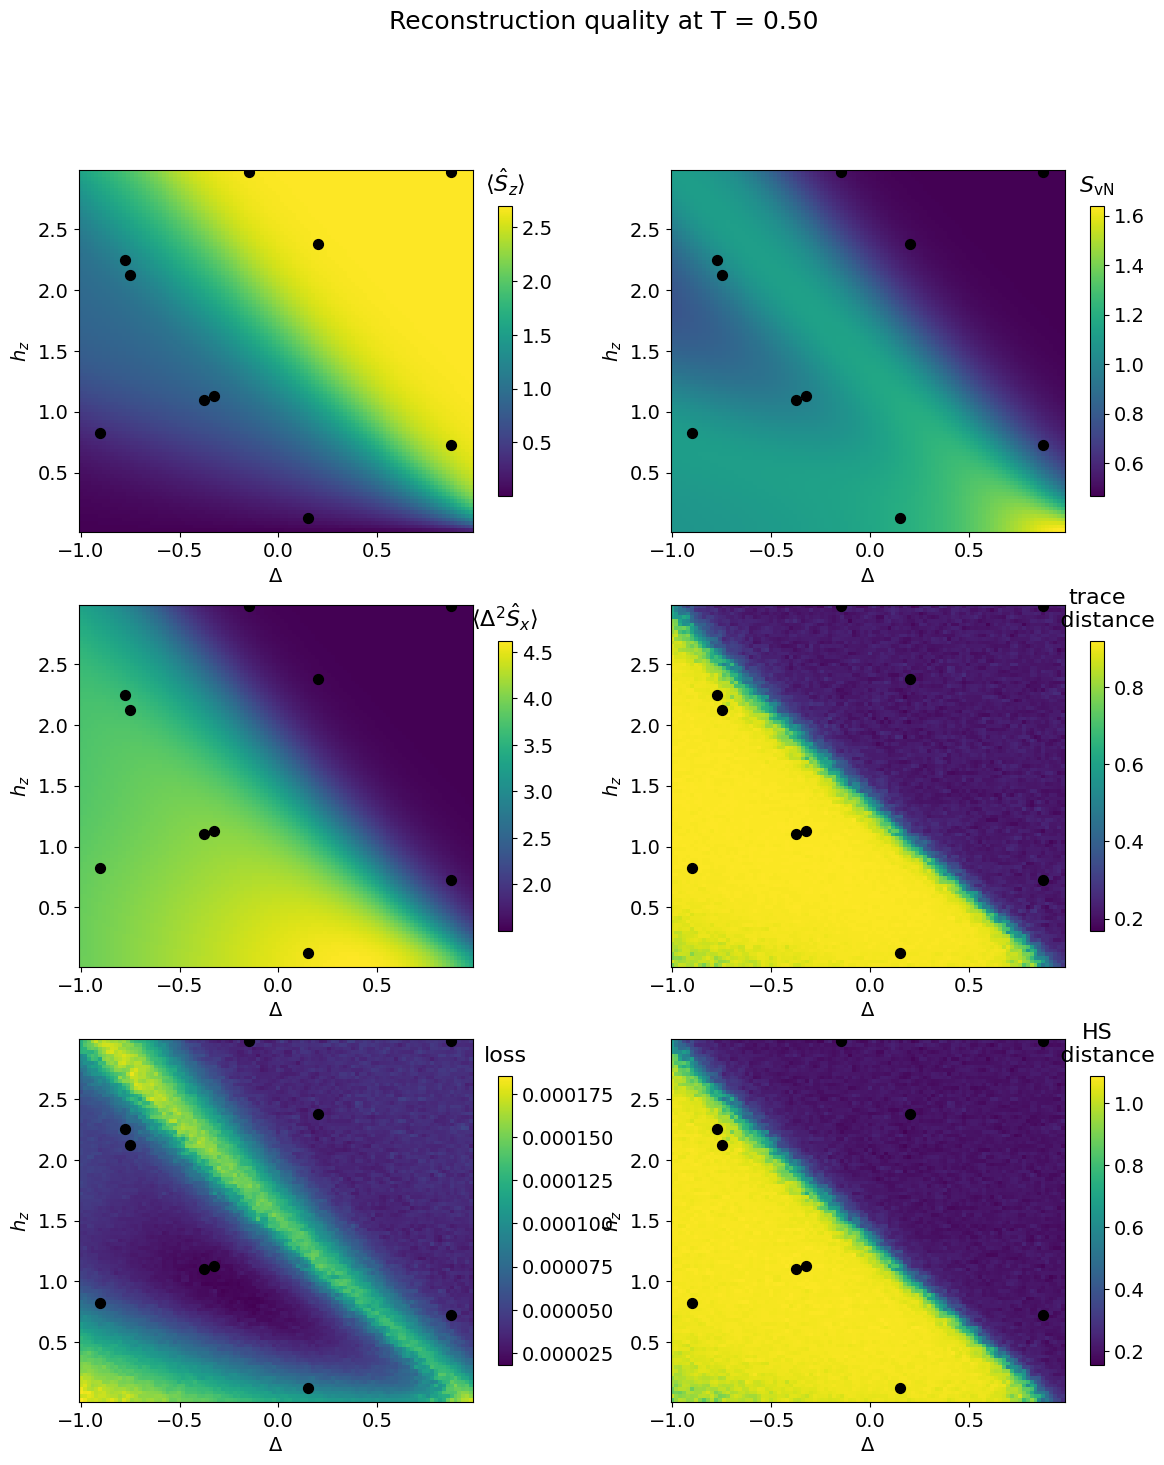

In [33]:
fig, ax = plt.subplots(3, 2, figsize = (14, 16))

fig.suptitle("Reconstruction quality at T = {:2.2f}".format(T))

observable = 'Sz'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,0], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
ax[0,0].set_xlabel(r'$\Delta$')
 
observable = 'SvN'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded['SvN']
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
ax[0,1].set_xlabel(r'$\Delta$')
ax[0,1].set_ylabel(r'$h_z$')

observable = 'Sx_var'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,0], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
ax[1,0].set_xlabel(r'$\Delta$')


observable = 'loss'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[2,0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[2,0], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(get_observable_string(observable), pad=10)  # Label on top of the colorbar
ax[2,0].set_xlabel(r'$\Delta$')


observable = 'tr_distance'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded['tr_distance']
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[1,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[1,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title('trace\n   distance', pad=10)  # Label on top of the colorbar

observable = 'hs_distance'
x = df_all_decoded["delta"]
y = df_all_decoded["hz"]
z = df_all_decoded['hs_distance']
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = ax[2,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=ax[2,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title('HS\n   distance', pad=10)  # Label on top of the colorbar

for i in range(0,2):
    for j in range(0,3):
        ax[j,i].scatter(df["delta"], df["hz"], color="black", s=50)

        ax[j,i].set_xlabel(r'$\Delta$')
        ax[j,i].set_xlabel(r'$\Delta$')
        ax[j,i].set_ylabel(r'$h_z$')
        ax[j,i].set_ylabel(r'$h_z$')
plt.savefig("phase_diagram_quantum_distance_temperature_T.{:2.2f}.png".format(T))
plt.show()

![](phase_diagram_quantum_distance_temperature_T.0.50.png)

# PCA on latent representation

Now, let's have a look at linear PCA analysis of low-dimensional latent representation of our ground states

(9520, 1040)


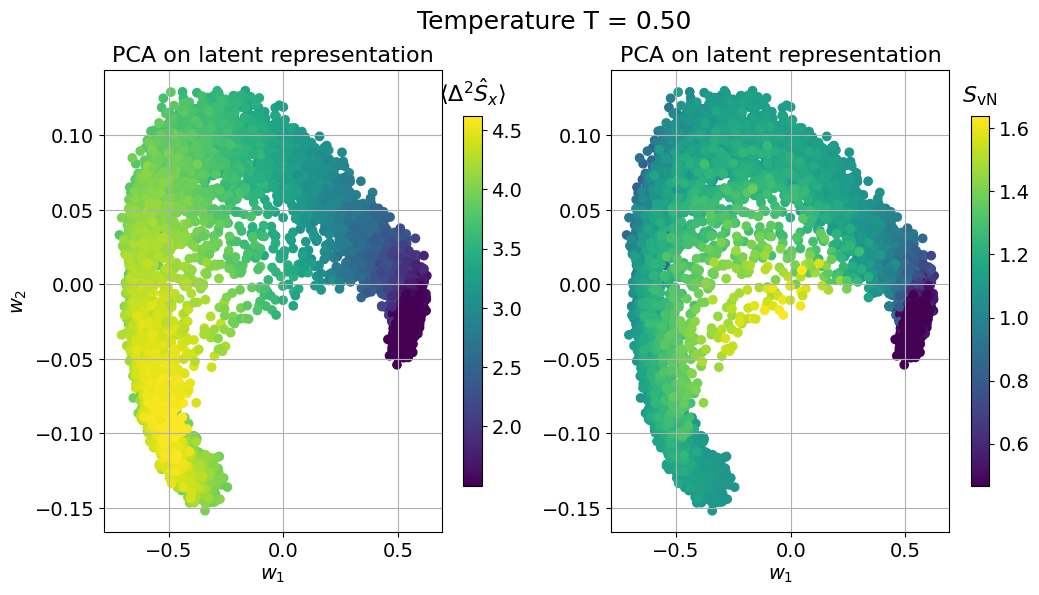

In [34]:
all_vectors = np.stack(df_all_decoded['A_vec_latent'])
print(all_vectors.shape)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_vectors)

# Add PCA results to DataFrame
df_all_decoded['PCA1'] = reduced_data[:, 0]
df_all_decoded['PCA2'] = reduced_data[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Temperature T = {:2.2f}".format(T))
observable_1 = 'Sx_var'
observable_2 = 'SvN'
# Subplot 1: PCA scatter plot
sc1 = axes[0].scatter(df_all_decoded['PCA1'], df_all_decoded['PCA2'], c=df_all_decoded[observable_1], cmap=cmap_string, alpha=1)
cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(get_observable_string(observable_1), pad=10)  # Label on top of the colorbar

# Subplot 1: PCA scatter plot
sc1 = axes[1].scatter(df_all_decoded['PCA1'], df_all_decoded['PCA2'], c=df_all_decoded[observable_2], cmap=cmap_string, alpha=1)
cbar1 = fig.colorbar(sc1, ax=axes[1], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(get_observable_string(observable_2), pad=10)  # Label on top of the colorbar

axes[0].set_xlabel(r'$w_1$')
axes[1].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_2$')
axes[0].set_title('PCA on latent representation'.format(T))
axes[1].set_title('PCA on latent representation'.format(T))
axes[0].grid(True)
axes[1].grid(True)
plt.savefig("fig2.png")
plt.show()

# Tasks:
Consider $L = 6$. 
1. Propose your own AE architecture, training hyperparameters, and regularization techniques.
2. Analyze how clusterization (PCA/t-SNE) on Cholesky vectors and on AE latent representation is affected by temperature T. What is the maximal T for which clusterization is still visible? Maybe clusterization is only for pure states?
3. Analyze how reconstruction quality is affected by temperature of Gibbs states.
4. Perform these analysis for both periodic and open boundary conditions.
5. Analyze the situation when training data are only from a finite a part of the phase diagram (with a given value of $\langle\hat{S}_z\rangle$)
6. Extra: Analyze quality reconstruction with system size $L = 3, 4, 5, 6, 7, 8, 9, 10$ - use sparse representation for matrix operations!